# CITE-seq reference mapping with totalVI

With totalVI, we can train a reference model that can be used for mapping new query data. Here we dive into this functionality.

If you use totalVI, please consider citing:

- Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [3]:
import os
import tempfile
from pathlib import Path

import pandas as pd 

import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch
import umap
from scvi.model import TOTALVI
from sklearn.ensemble import RandomForestClassifier

## Building a reference model

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

This dataset was filtered as described in the scvi-tools manuscript (low quality cells, doublets, lowly expressed genes, etc.).

```{important}
Here we use the argument `mask_protein_batches=5`. What this does is treats the protein data in 5/24 of the batches in this dataset as missing. This will help totalVI integrate query data that has a subset of the proteins measured in this dataset or no proteins at all (i.e., just scRNA-seq data).
```

In [5]:
# os.listdir("../data/")
# # h5s = []

# # for entry in os.listdir("../data/"):
# #     if entry[-3:] == '.h5':
# #         print(entry)

In [6]:
# citeseq_train  = pd.read_hdf("../data/train_cite_targets.h5")

# rnaseq_train  = pd.read_hdf("../data/train_cite_inputs.h5")




In [7]:
# citeseq_train.columns

In [8]:
# metadata = pd.read_csv("../data/metadata.csv",index_col=0)


In [9]:
# metadata[metadata['technology']=='citeseq']

In [10]:
# rnaseq_train

In [11]:
# citeseq_test  = pd.read_hdf("../data/test_cite_inputs.h5")

# rnaseq_test  = pd.read_hdf("../data/test_cite_inputs_day_2_donor_27678.h5")



In [12]:
# metadata_test = pd.read_csv("../data/metadata_cite_day_2_donor_27678.csv")


In [13]:
# pd.read_csv("../data/evaluation_ids.csv",index_col=0)


In [14]:
# pd.read_csv("../data/sample_submission.csv",index_col=0)

In [6]:
adata = sc.read("../data/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")

/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
# adata2 = sc.read("../data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [17]:
# list(citeseq_train.columns)

In [18]:
# adata.X # contains normalized to_df()
# adata.raw is emply 

# adata.layers['counts'].toarray()  # contains raw 


In [19]:
# adata.var

In [7]:
adata_cite = adata[:,adata.var['feature_types']=='ADT']

adata_rna = adata[:,adata.var['feature_types']=='GEX']

In [8]:
adata_rna.obsm['protein_counts'] = adata_cite.layers['counts'].toarray() # raw protein counts 

/tmp/ipykernel_1455670/582819414.py:1: ImplicitModificationWarning: Setting element `.obsm['protein_counts']` of view, initializing view as actual.
  adata_rna.obsm['protein_counts'] = adata_cite.layers['counts'].toarray() # raw protein counts


In [9]:
adata_rna.raw = adata_rna

In [10]:
adata_rna

AnnData object with n_obs × n_vars = 90261 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

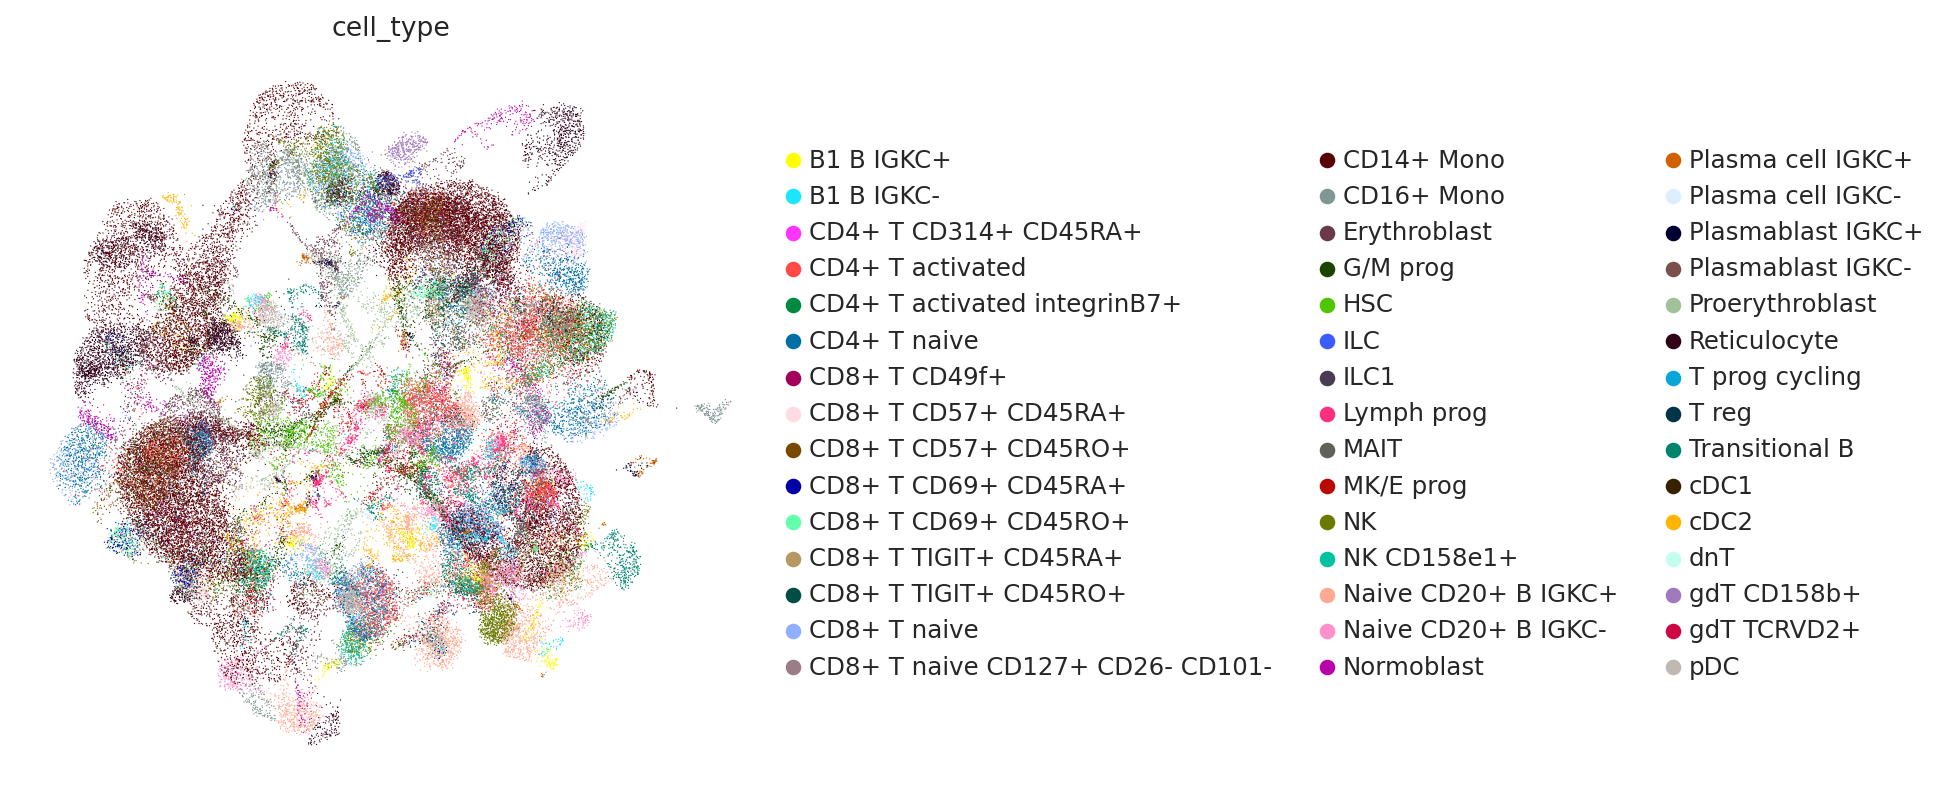

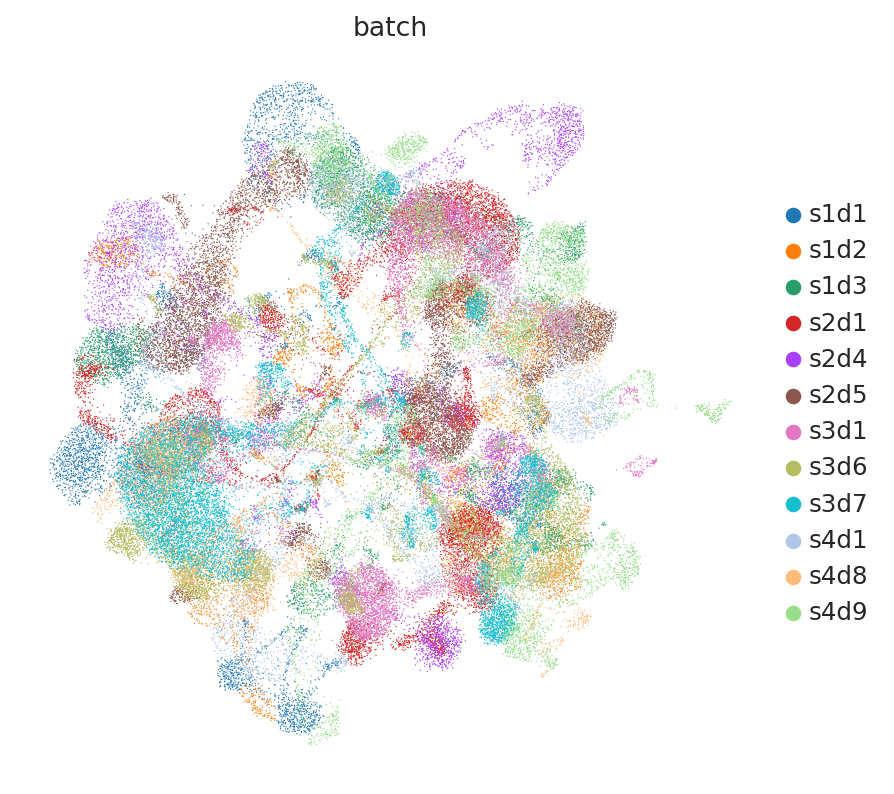

In [24]:
for entry in ['cell_type','batch']:
    sc.pl.embedding(adata_rna,'GEX_X_umap',color=entry,save='_gex_umap_' + entry + '.pdf')

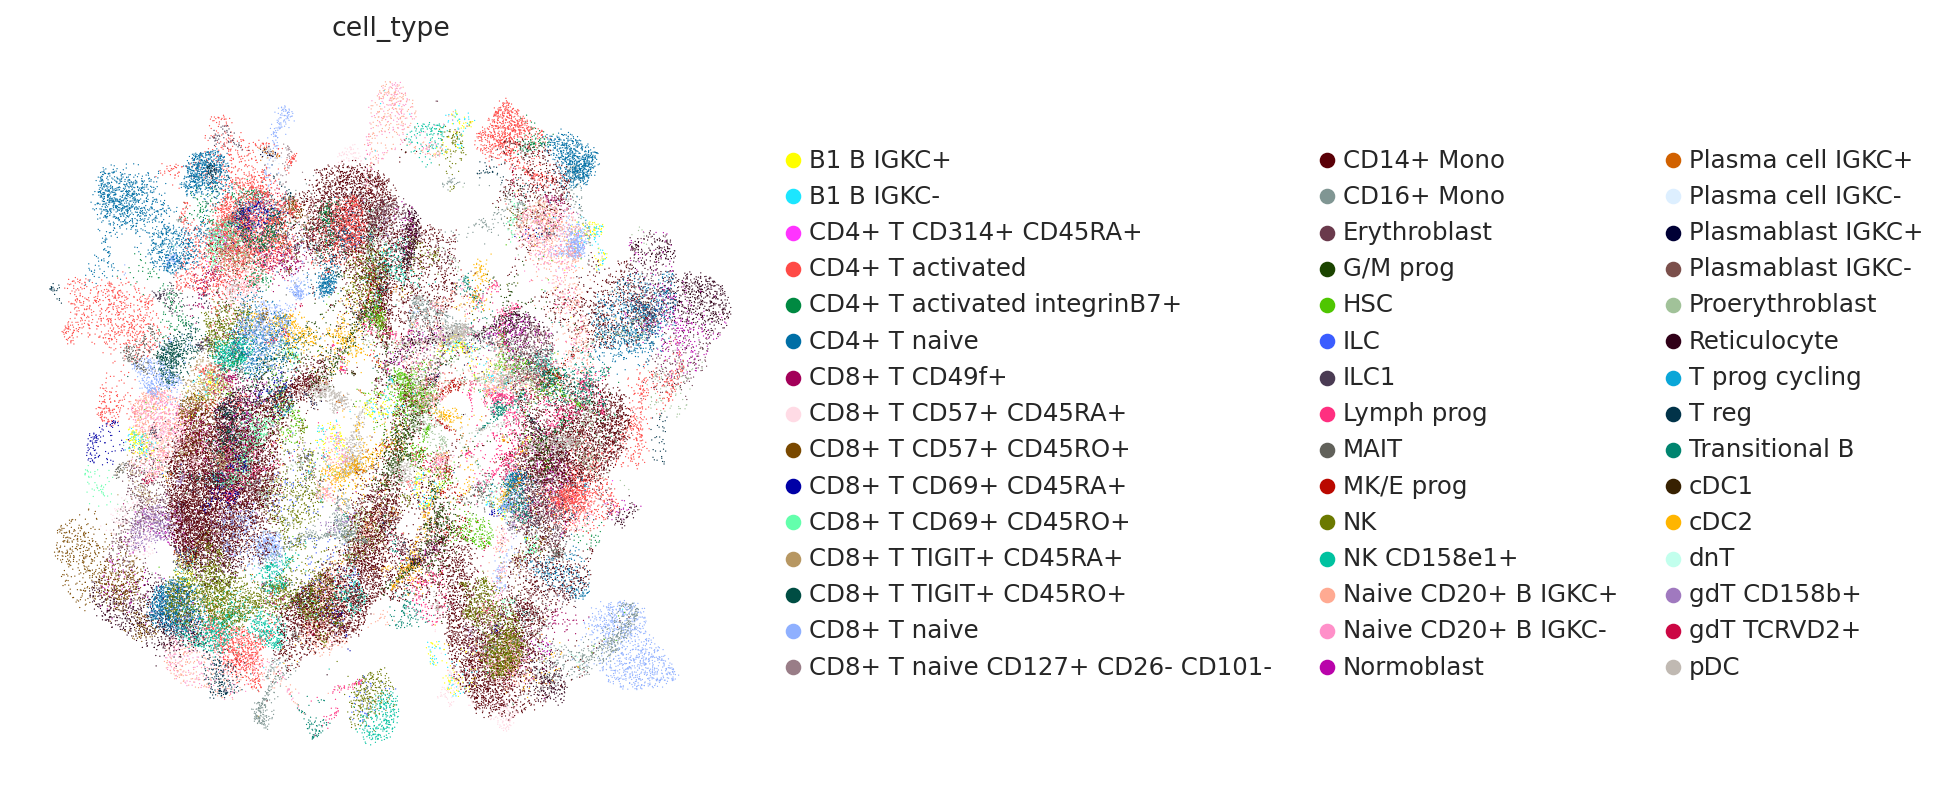

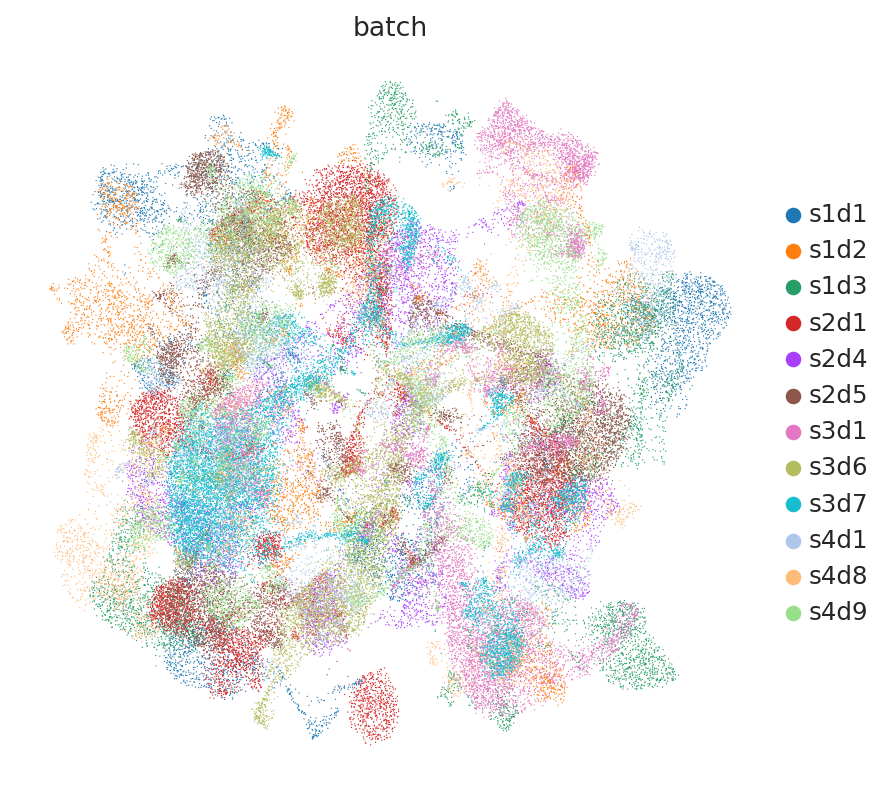

In [11]:
for entry in ['cell_type','batch']:
    sc.pl.embedding(adata_rna,'ADT_X_umap',color=entry,save='_adt_umap_' + entry + '.pdf')

In [56]:
# adata = scvi.data.pbmc_seurat_v4_cite_seq(
#     save_path=save_dir.name,
#     mask_protein_batches=5,
# )
# adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.raw = adata

In [12]:
adata_rna.obs['is_train'].value_counts()


# train - training 
# iid holdout - validation
# test = test 


is_train
train          66175
test           15066
iid_holdout     9020
Name: count, dtype: int64

In [13]:
# subset to train-val set 

adata_trainval = adata_rna[adata_rna.obs['is_train'].isin(['train','iid_holdout'])]

In [14]:
sc.pp.highly_variable_genes(
    adata_trainval,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
    layer="counts",
)
adata_trainval

/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


AnnData object with n_obs × n_vars = 75195 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'batch_colors', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [28]:
# subset to train set 

# adata_train = adata_trainval[adata_trainval.obs['is_train'].isin(['train'])]

In [15]:
adata_train = adata_trainval.copy()

In [30]:
TOTALVI.setup_anndata(
    adata_train,
    layer="counts",
    batch_key="batch",
    protein_expression_obsm_key="protein_counts",
)

INFO     Generating sequential column names                                                                        


### Prepare and run model

Here we use the scArches-specific totalVI parameters, as shown in the scArches tutorial.

Rather than training the model here, which would take 1 hour, we instead download a pretrained object.

In [32]:
save_dir.name = './'

In [33]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    n_layers_decoder=2,
    n_layers_encoder=2,
)

model = TOTALVI(adata_train, **arches_params)
model.train(max_epochs=250)

model_dir = os.path.join(save_dir.name, "scRNA_reference_model")
model.save(model_dir, overwrite=True)

INFO     Computing empirical prior initialization for protein background.                                          


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/core/optimizer.py:316: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-pack

Training:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [70]:
# def download_model(save_path: str, fname: str = "legacy_seurat_reference_model"):
#     """Download the pre-trained model."""
#     paths = pooch.retrieve(
#         url="https://figshare.com/ndownloader/files/30929902",
#         known_hash="422706d6af4ec6b3b91f547d7e8c97812b86a548e0d19b1d85d9cfed686a5130",
#         fname=fname,
#         path=save_path,
#         processor=pooch.Unzip(),
#     )
#     paths.sort()
#     return str(Path(paths[0]).parent)

In [16]:
# legacy_model_dir = download_model(save_dir.name)
model_dir = os.path.join('./', "scRNA_reference_model")
# TOTALVI.convert_legacy_save(legacy_model_dir, model_dir)

model = TOTALVI.load(model_dir, adata=adata_train)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ./scRNA_reference_model/model.pt already downloaded                                                  


/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(mode

INFO     Computing empirical prior initialization for protein background.                                          


In [17]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `TOTALVI.setup_anndata` with arguments:

{
│   'protein_expression_obsm_key': 'protein_counts',
│   'protein_names_uns_key': None,
│   'batch_key': 'batch',
│   'layer': 'counts',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  12   │
│         n_cells          │ 75195 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│        n_proteins        │  134  │
│          n_vars          │ 4000  │
└──────────────────────────┴───────┘

                 Data Registry                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃     scvi-tools Location      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │    adata.layers['counts']    │
│    batch     │   adata.obs['_scvi_batch']   │
│    labels    │  adata.obs['_scvi_labels']   │
│   proteins   │ adata.obsm['protein_counts'] │
└──────────────┴──────────────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d1    │          0          │
│                    │    s1d2    │          1          │
│                    │    s1d3    │          2          │
│                    │    s2d1    │          3          │
│                    │    s2d4    │          4          │
│                    │    s2d5    │          5          │
│                    │    s3d1    │          6          │
│                    │    s3d6    │          7          │
│                    │    s3d7    │          8          │
│                    │    s4d1    │          9          │
│                    │    s4d8    │         10          │
│                    │    s4d9    │         11          │
└────────────────────┴────────────┴─────────────────────┘

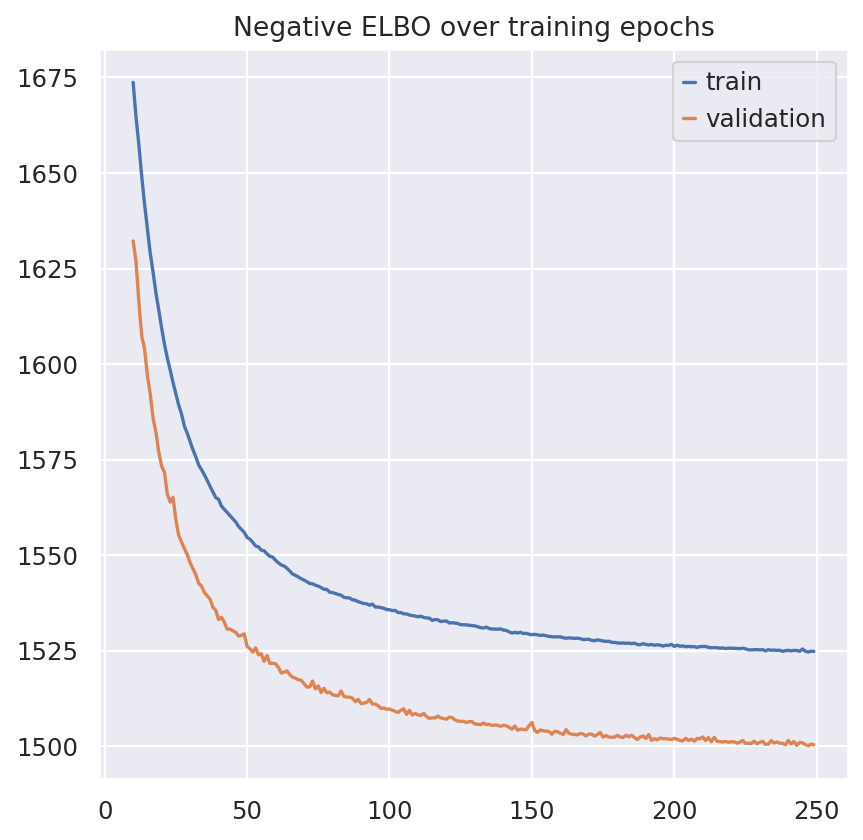

In [18]:
plt.plot(model.history["elbo_train"].iloc[10:], label="train")
plt.plot(model.history["elbo_validation"].iloc[10:], label="validation")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [20]:
TOTALVI_LATENT_KEY = "X_totalvi"

adata_train.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

### Train a classifier on the latent space

The representation of the reference data will not change when the model gets updated with query data. Therefore, we can train any simple classifier on the latent space. Here we use a Random Forest from scikit-learn.

By storing the classifier object in our totalVI instance (and giving it an attribute that ends with `_`), we can automatically save and load this classifier along with our model.

In [21]:
# y_train = adata.obs["celltype.l2"].astype("category").cat.codes.to_numpy()
# X_train = adata.obsm[TOTALVI_LATENT_KEY]
# clf = RandomForestClassifier(
#     random_state=1,
#     class_weight="balanced_subsample",
#     verbose=1,
#     n_jobs=-1,
# )
# clf.fit(X_train, y_train)

# model.latent_space_classifer_ = clf

### Inspect reference model

We can view the latent space using UMAP and plot the study-derived cell type labels.

Here we use the umap API instead of scanpy so that we can later use the same umap object on the query data.

In [22]:
TOTALVI_UMAP_KEY = "X_umap"

X = adata_train.obsm[TOTALVI_LATENT_KEY]
trans = umap.UMAP(
    n_neighbors=10,
    random_state=42,
    min_dist=0.4,
)
adata_train.obsm[TOTALVI_UMAP_KEY] = trans.fit_transform(X)

model.umap_op_ = trans

/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
adata_train

AnnData object with n_obs × n_vars = 75195 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', '_scvi_labels', '_scvi_batch'
    var: 'feature_types', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'batch_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts', 'X_totalvi', 'X_umap'
    layers: 'counts'

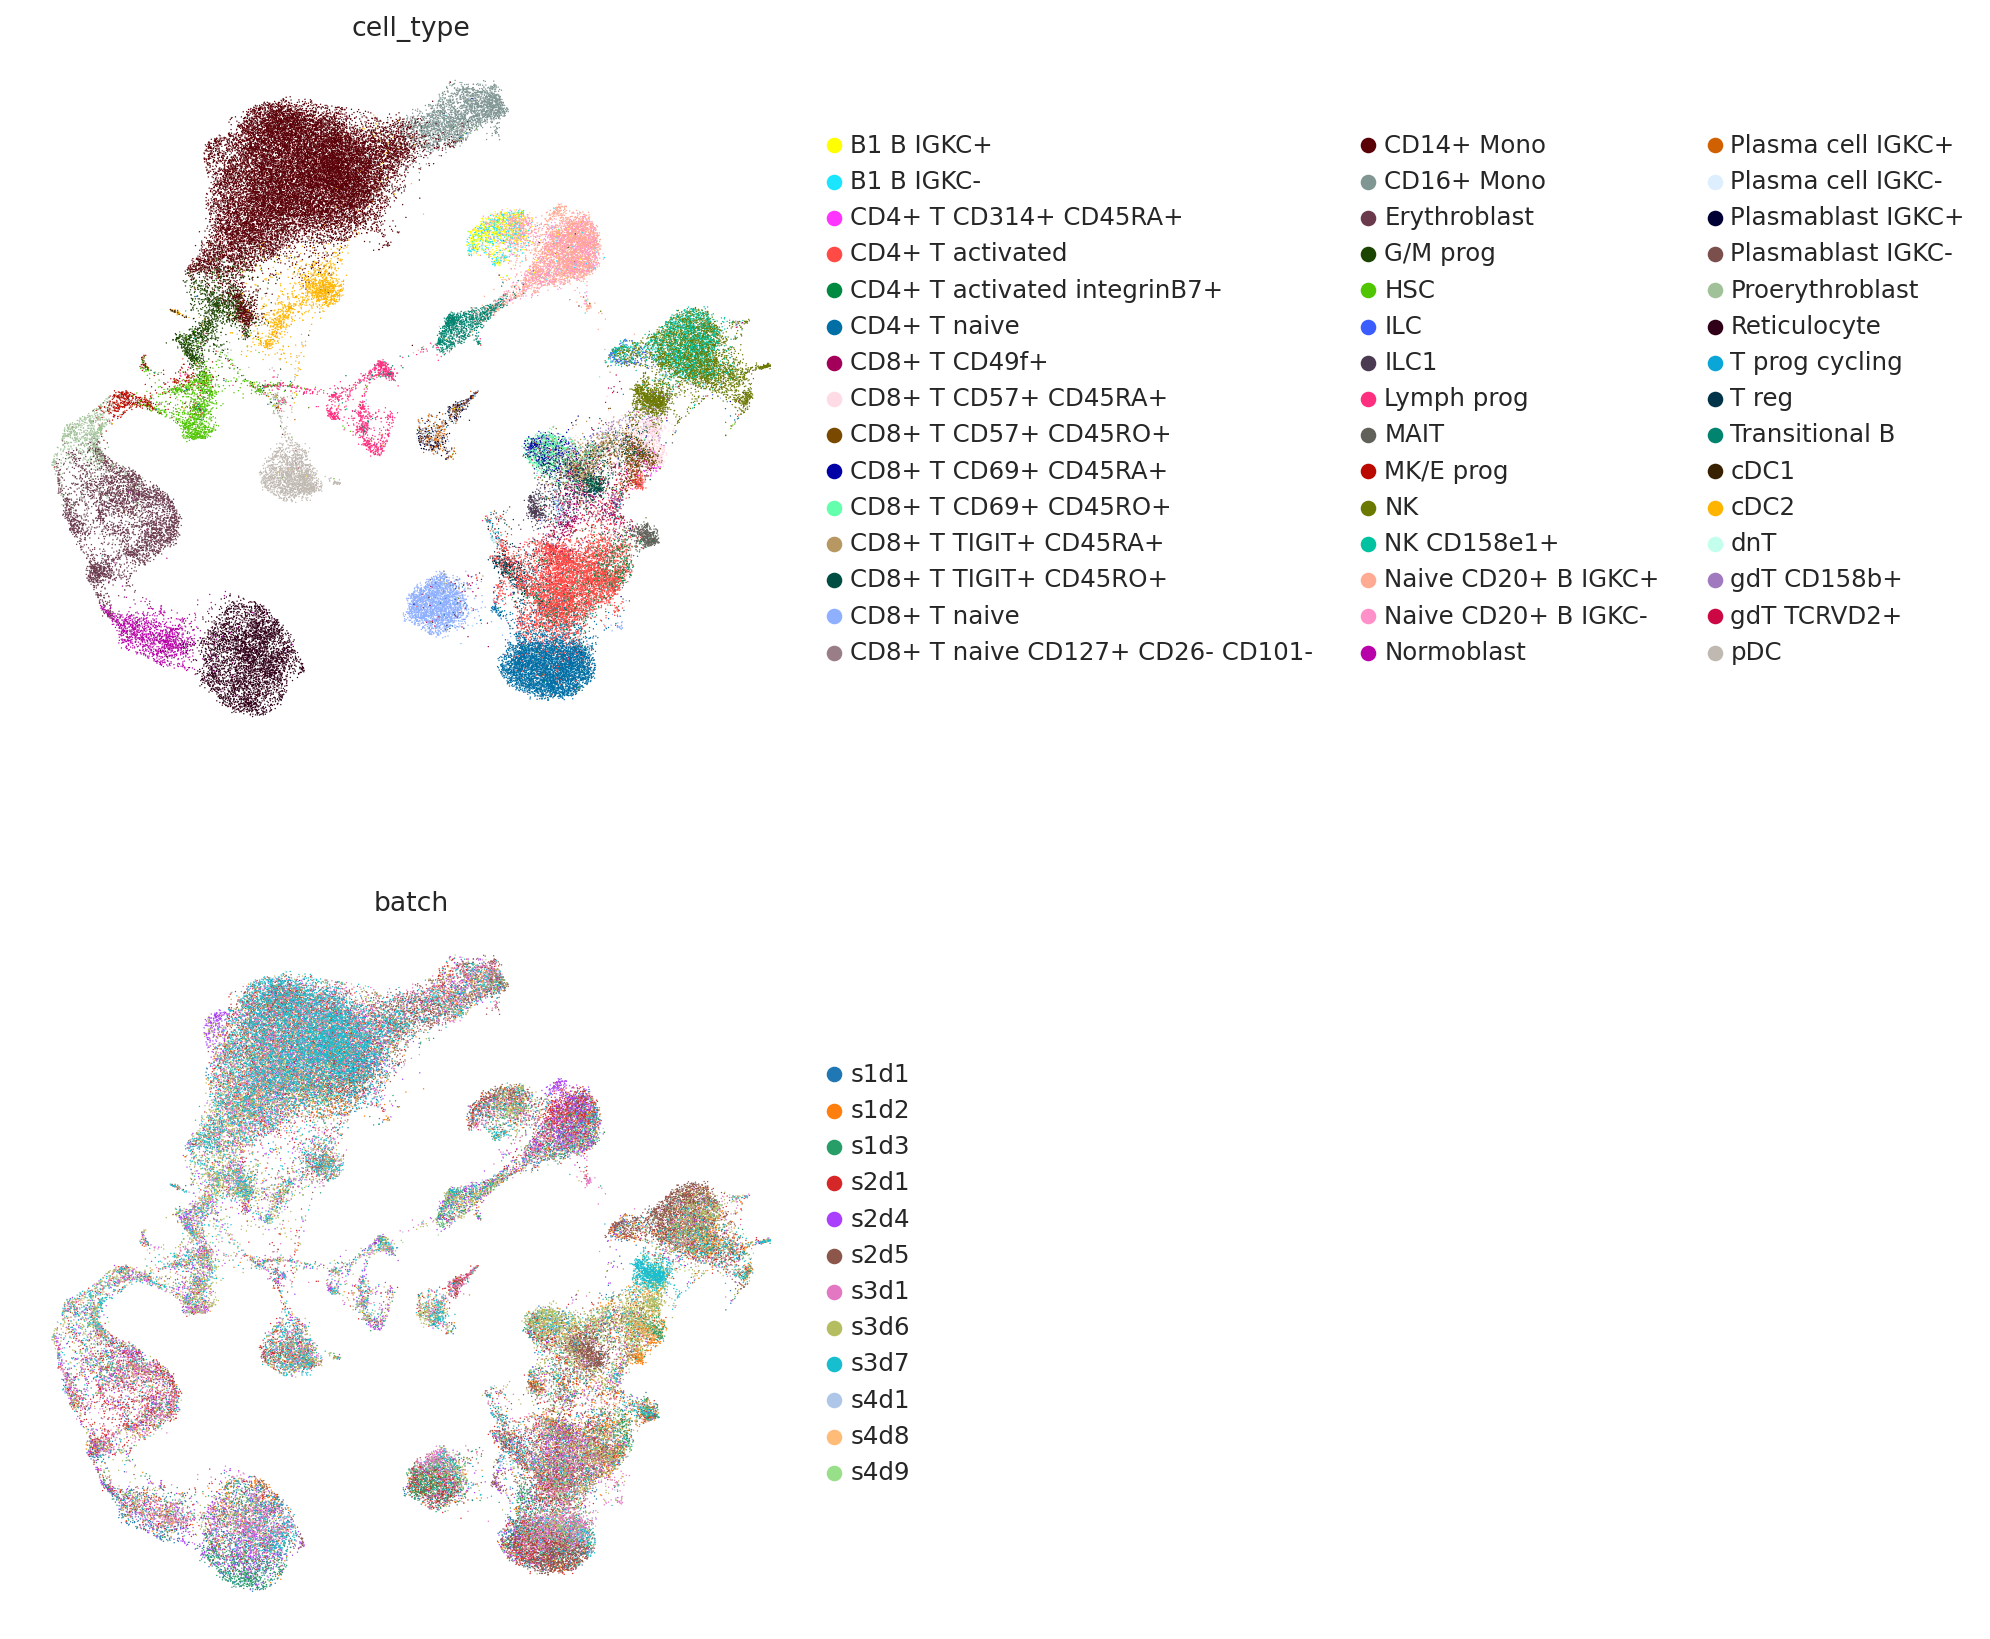

In [24]:
sc.pl.umap(
    adata_train,
    color=['cell_type', 'batch'],
    frameon=False,
    ncols=1, save='_latent_space_scRNA_ref.pdf'
)

## Map query data

Now we download our query data and cover the preprocessing necessary to map with our reference model.

In this case our query data are also PBMCs and come from the following study:

- Arunachalam, Prabhu S., et al. "Systems biological assessment of immunity to mild versus severe COVID-19 infection in humans." Science 369.6508 (2020): 1210-1220.

This dataset is also CITE-seq, but contains a subset of the proteins of the reference data.

In [25]:
# query_path = os.path.join(save_dir.name, "covid_cite.h5ad")

# query = sc.read(query_path, backup_url="https://ndownloader.figshare.com/files/27458837")

### Preprocessing

First we remove any doublets from the query dataset using Scrublet. This has to be run per batch, which in this dataset is denoted with `"set"`.

In [18]:
# query.obs["doublet_scores"] = 0
# query.obs["predicted_doublets"] = True
# for s in np.unique(query.obs["set"]):
#     mask = query.obs["set"] == s
#     counts_matrix = query[mask].X.copy()
#     scrub = scr.Scrublet(counts_matrix)
#     doublet_scores, predicted_doublets = scrub.scrub_doublets()
#     query.obs["doublet_scores"].iloc[mask] = doublet_scores
#     query.obs["predicted_doublets"].iloc[mask] = predicted_doublets


Preprocessing...


Simulating doublets...


Embedding transcriptomes using PCA...


Calculating doublet scores...


Automatically set threshold at doublet score = 0.37
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 40.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
Elapsed time: 33.0 seconds


/tmp/ipykernel_158/1351898786.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_158/1351898786.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Preprocessing...


Simulating doublets...


Embedding transcriptomes using PCA...


Calculating doublet scores...


Automatically set threshold at doublet score = 0.25
Detected doublet rate = 6.2%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.0%
Elapsed time: 35.9 seconds


/tmp/ipykernel_158/1351898786.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_158/1351898786.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pan

Next we do the following:

1. Store the counts in a layer, perform standard preprocessing
1. Add blank metadata that we will later fill in with predicted labels
1. Rename the batch key to correspond to the reference data
1. Add proteins with all 0 counts for the missing proteins in this query dataset

In [31]:
adata_rna.obs['is_train'].value_counts()

is_train
train          66175
test           15066
iid_holdout     9020
Name: count, dtype: int64

In [58]:
adata_test = adata_rna[adata_rna.obs['is_train']=='test']

In [59]:
adata_rna.obs['cell_type'].value_counts()

cell_type
CD14+ Mono                          21693
CD4+ T activated                     6966
CD4+ T naive                         5897
NK                                   5434
Reticulocyte                         4272
Erythroblast                         4039
Naive CD20+ B IGKC+                  3990
CD8+ T naive                         3107
CD16+ Mono                           2635
NK CD158e1+                          2167
Naive CD20+ B IGKC-                  1979
G/M prog                             1881
pDC                                  1758
HSC                                  1703
cDC2                                 1702
Lymph prog                           1681
Transitional B                       1575
Proerythroblast                      1512
CD8+ T CD57+ CD45RO+                 1470
Normoblast                           1435
CD8+ T CD57+ CD45RA+                 1303
CD8+ T TIGIT+ CD45RO+                1160
CD4+ T activated integrinB7+         1056
CD8+ T TIGIT+ CD45RA+   

In [60]:
adata_test

View of AnnData object with n_obs × n_vars = 15066 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'batch_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

In [61]:
adata_test.obsm['pc_orig'] = adata_test.obsm['protein_counts'].copy()

del adata_test.obsm['protein_counts']

/tmp/ipykernel_1455670/3428907098.py:1: ImplicitModificationWarning: Setting element `.obsm['pc_orig']` of view, initializing view as actual.
  adata_test.obsm['pc_orig'] = adata_test.obsm['protein_counts'].copy()


In [62]:
# query.layers["counts"] = query.X.copy()
# sc.pp.normalize_total(query, target_sum=1e4)
# sc.pp.log1p(query)
# query.raw = query
# subset to reference vars
adata_test = adata_test[:, adata_train.var_names].copy()

adata_test
#query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
#query.obs["celltype.l2"] = "Unknown"
# query.obs["orig.ident"] = query.obs["set"]
# query.obsm["X_umap"] = query.obs[["UMAP1", "UMAP2"]].values

# # reorganize query proteins, missing proteins become all 0
# for p in adata_train.obsm["protein_counts"].columns:
#     if p not in adata_test.obsm["protein_counts"].columns:
#         query.obsm["protein_counts"][p] = 0.0
# # ensure columns are in same order
# query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[
#     :, adata.obsm["protein_counts"].columns
# ]

AnnData object with n_obs × n_vars = 15066 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'batch_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'pc_orig'
    layers: 'counts'

For later visualization, we add some metadata to denote whether the dataset is reference of query

In [63]:
adata_train.obs["dataset_name"] = "Reference"
adata_test.obs["dataset_name"] = "Query"

### Query model training

In [ ]:
adata_test

In [65]:
adata_train.obsm['protein_counts'].shape

(75195, 134)

In [66]:
adata_test.obsm['protein_counts'] = np.zeros((adata_test.shape[0],adata_train.obsm['protein_counts'].shape[1]))

In [69]:
# adata_test.obsm['protein_counts']

In [68]:
query_model = TOTALVI.load_query_data(adata_test, model)
query_model.train(
    max_epochs=150,
    plan_kwargs={"weight_decay": 0.0, "scale_adversarial_loss": 0.0},
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Found batches with missing protein expression                                                             
INFO     Computing empirical prior initialization for protein background.                                          


/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/model/base/_save_load.py:136: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  model = cls(adata, **non_kwargs, **kwargs)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is 

Training:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


And now we retrieve the latent representation for the query data

In [70]:
TOTALVI_QUERY_LATENT_KEY = "X_totalvi_scarches"

adata_test.obsm[TOTALVI_QUERY_LATENT_KEY] = query_model.get_latent_representation(adata_test)

### Query cell type prediction

We can use the random forest that we previously trained using the latent representation of the query data in the updated model!

In [71]:
# # predict cell types of query
# predictions = query_model.latent_space_classifer_.predict(query.obsm[TOTALVI_QUERY_LATENT_KEY])
# categories = adata.obs["celltype.l2"].astype("category").cat.categories
# cat_preds = [categories[i] for i in predictions]
# query.obs["celltype.l2"] = cat_preds
# query.obs["predicted_l2_scarches"] = cat_preds

### Evaluate label transfer

Now we plot the predicted labels and the labels from the query study (here denoted as `"final_clust_review"`) on the UMAP coordinated used in the query study. We can see that we have an overall strong concordance, but also some important differences. For example, the study found a population of monocytes with interferon signaling, but as the reference contains no such cell type, it can only predict them to be CD14 monocytes.

In [72]:
# sc.pl.umap(
#     query,
#     color=["celltype.l2", "final_clust_review"],
#     frameon=False,
#     ncols=1,
# )

### Use reference UMAP

We can also use the same UMAP operator from the reference step to visualize our query data.

In [73]:
TOTALVI_UMAP_PROJECT_KEY = "X_umap_project"

adata_test.obsm[TOTALVI_UMAP_PROJECT_KEY] = query_model.umap_op_.transform(
    adata_test.obsm[TOTALVI_QUERY_LATENT_KEY]
)

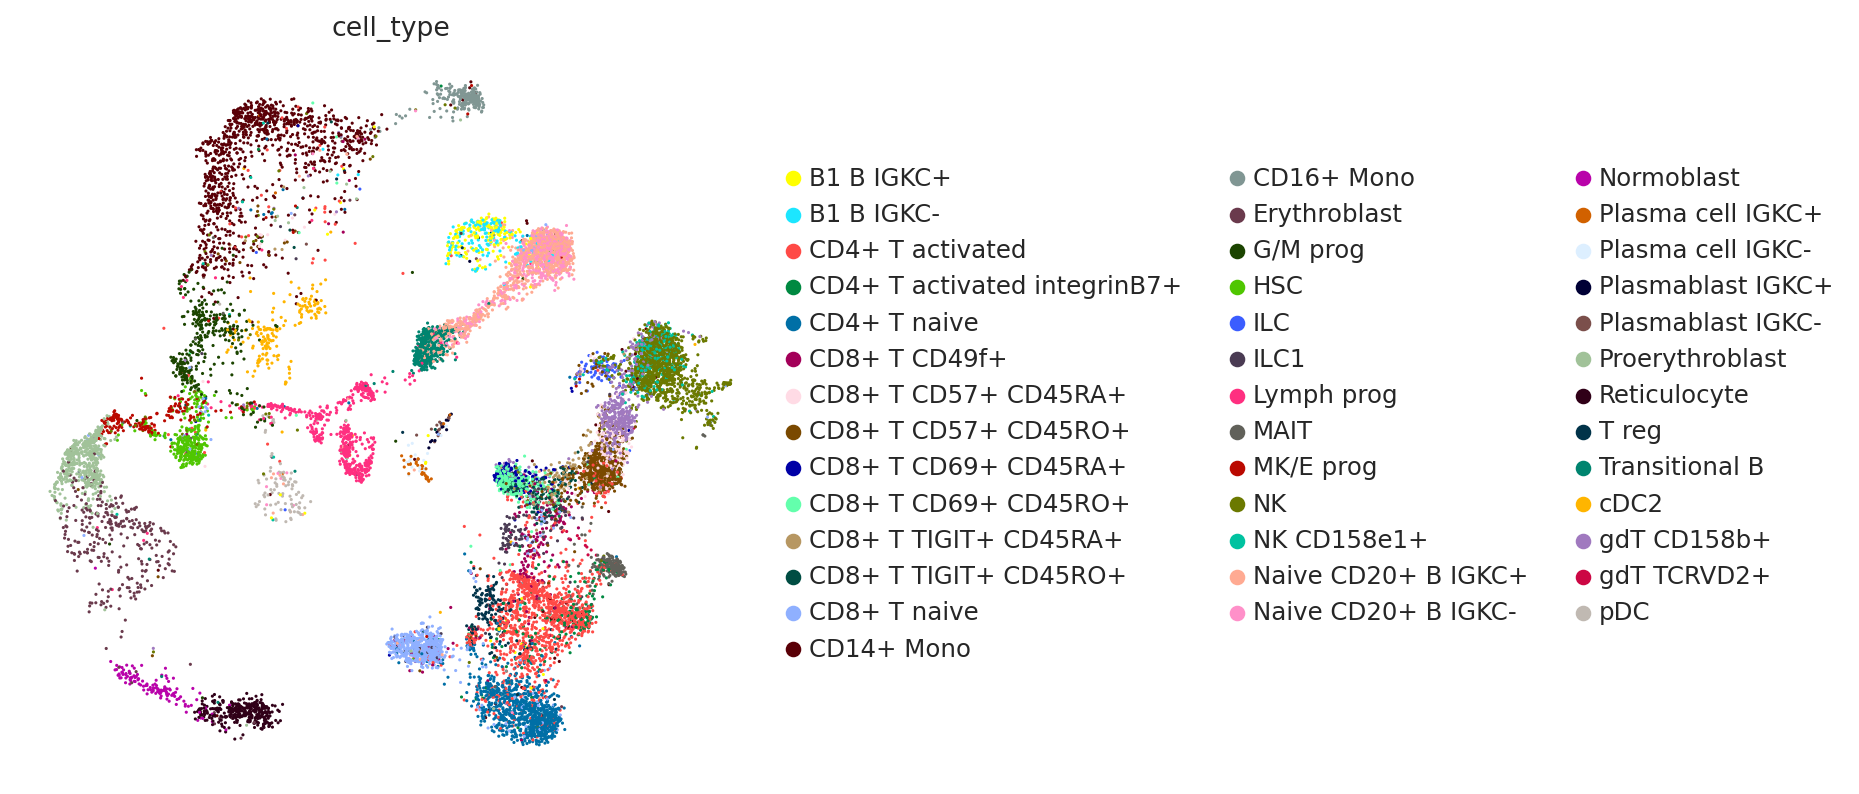

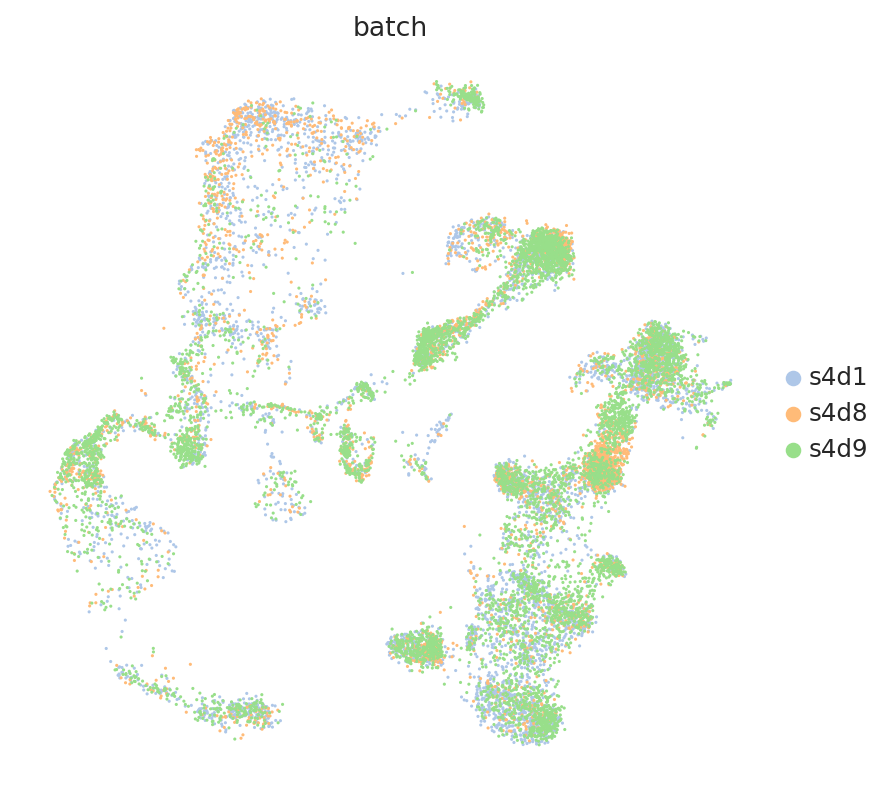

In [74]:
for entry in ["cell_type", "batch"]:
    sc.pl.embedding(
    adata_test,
    TOTALVI_UMAP_PROJECT_KEY,
    color=entry,
    frameon=False,
    ncols=1,save='_test_data.pdf'
)

And finally we can combine the umaps together and visualize jointly.

In [75]:
umap_adata = sc.AnnData(
    np.concatenate(
        [
            adata_test.obsm["X_umap_project"],
            adata_train.obsm["X_umap"],
        ],
        axis=0,
    )
)
umap_adata.obs["cell_type"] = np.concatenate(
    [adata_test.obs["cell_type"].values, adata_train.obs["cell_type"].values]
)
umap_adata.obs["batch"] = np.concatenate(
    [adata_test.obs["batch"].values, adata_train.obs["batch"].values]
)
umap_adata.obs["dataset"] = np.concatenate(
    [adata_test.shape[0] * ["query"], adata_train.shape[0] * ["reference"]]
)
umap_adata.obsm["X_umap"] = umap_adata.X

/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


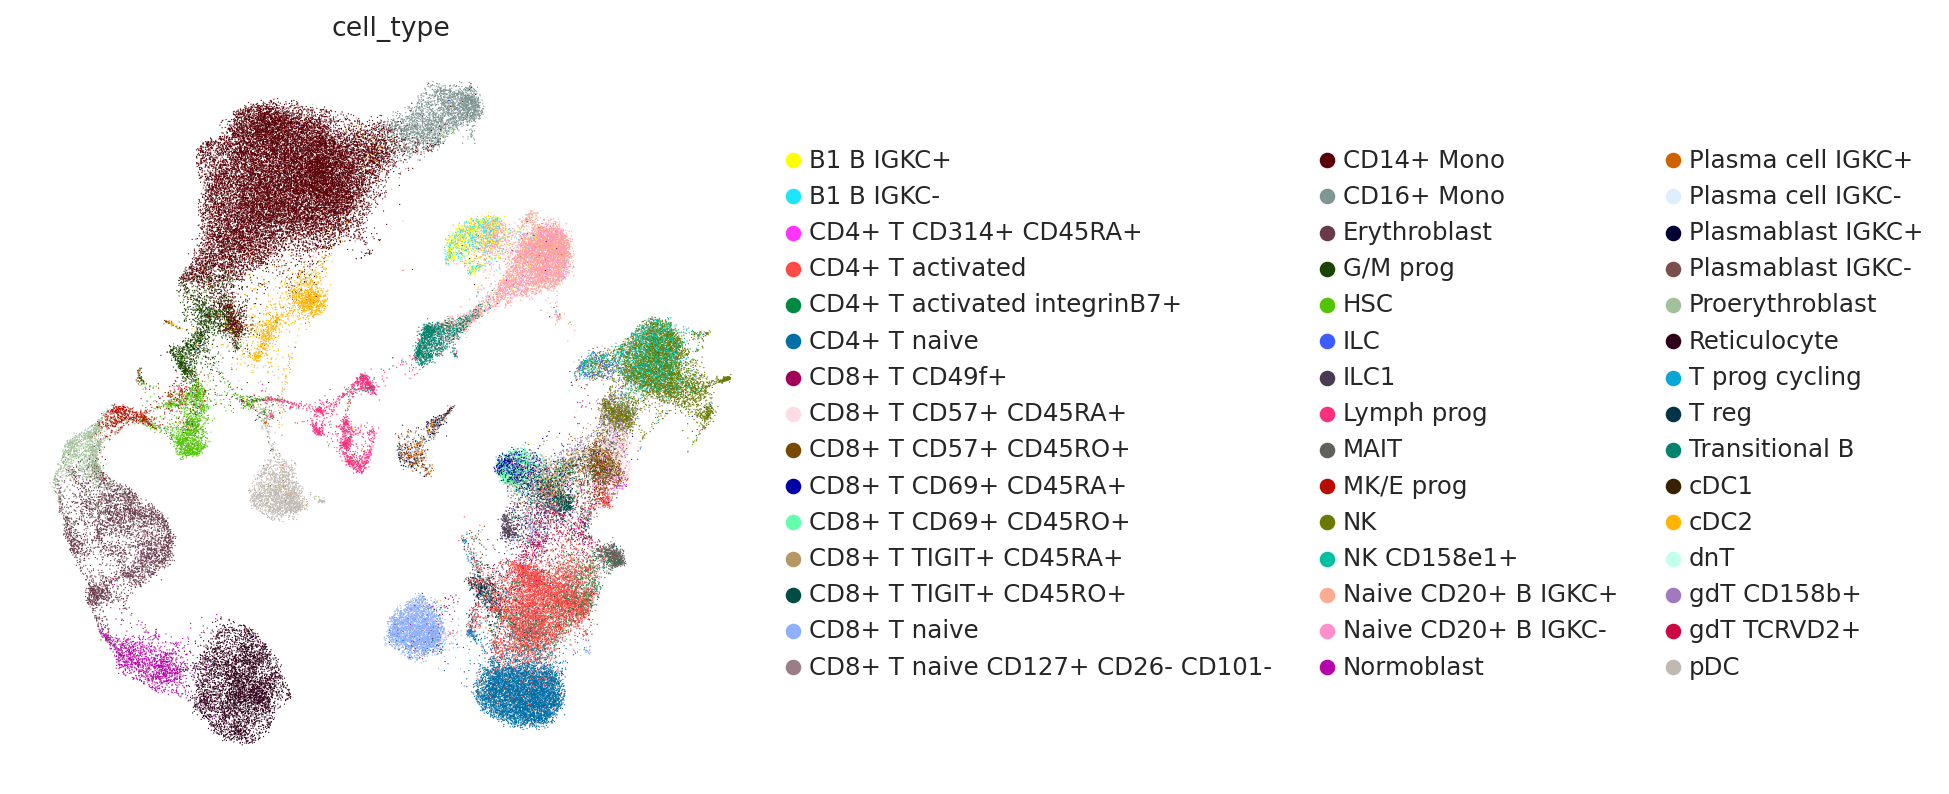

/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/project/mlobo6/miniconda3/envs/scvi-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


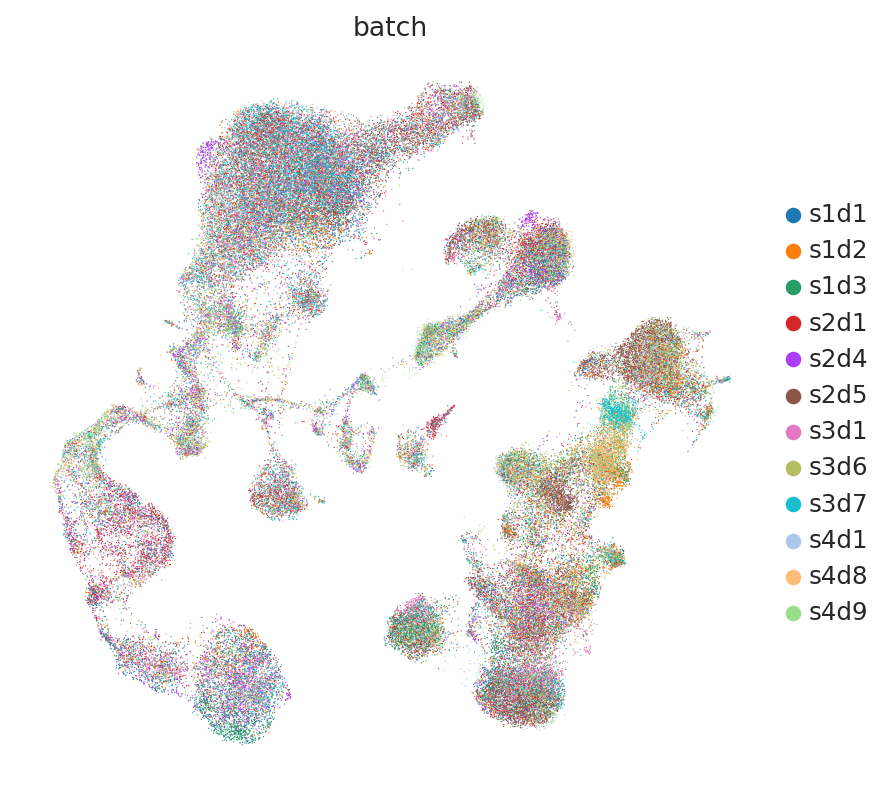

In [76]:

inds = np.random.permutation(np.arange(umap_adata.shape[0]))
for entry in ["cell_type", "batch"]:
    sc.pl.umap(
        umap_adata[inds],
        color=entry,
        frameon=False,
        ncols=1,save='_combined' + entry + '.pdf'
    )

In [79]:
adata_test

AnnData object with n_obs × n_vars = 15066 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'dataset_name', '_scvi_labels', '_scvi_batch'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'batch_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'pc_orig', 'protein_counts', 'X_totalvi_scarches', 'X_umap_project'
    layers: 'counts'

In [80]:
# predict protein counts + measure RMSE, correlation 

imputed_rna, imputed_proteins = query_model.get_normalized_expression(
    adata_test,
    return_mean=True
)


In [82]:
adata_test.obsm['protein_counts_pred'] = np.array(imputed_proteins)

In [87]:
# metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [90]:
adata_test.obsm['pc_orig'].shape

(15066, 134)

In [92]:
rmse = np.sqrt(mean_squared_error(adata_test.obsm['protein_counts_pred'], adata_test.obsm['pc_orig']))
# r2 = r2_score(adata_test.obsm['protein_counts_pred'], adata_test.obsm['pc_orig'])
pcc = pd.DataFrame(adata_test.obsm['pc_orig']).corrwith(pd.DataFrame(adata_test.obsm['protein_counts_pred']), axis = 1, method='pearson') # if not doing rank correlation, normalization will matter 
avg_corr_pearson = pcc.mean()
ssim_val = ssim(adata_test.obsm['pc_orig'], adata_test.obsm['protein_counts_pred'], data_range=adata_test.obsm['protein_counts_pred'].max() - adata_test.obsm['protein_counts_pred'].min())

results_df = pd.DataFrame({
      'RMSE': [rmse],
      'Pearson': avg_corr_pearson,
      'SSIM':ssim_val
  })


(15066,)


In [93]:
pcc

0        0.933746
1        0.497092
2        0.907338
3        0.947637
4        0.648255
           ...   
15061    0.854889
15062    0.969359
15063    0.947767
15064    0.878574
15065    0.956282
Length: 15066, dtype: float64